<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation for Binary MNIST Model using RISE

This notebook demonstrates how to apply the RISE explainability method on a pretrained binary MNIST model using a hand-written digit image. It visualizes the relevance attributions for each pixel/super-pixel by displaying them on top of the input image.<br>

[RISE](http://bmvc2018.org/contents/papers/1064.pdf) is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

### Libraries

In [2]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import dianna
import onnxruntime
import numpy as np
from pathlib import Path
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import softmax
from dianna import visualization
from dianna.utils.downloader import download

#### 1 - Loading the model and the dataset
Loads pretrained binary MNIST model and the image to be explained.

Load saved binary MNIST data.

In [3]:
# load dataset
data = np.load(download('binary-mnist.npz', 'data'))
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 1, 28, 28])
y_test = data['y_test']

Load the pretrained binary MNIST model and define a model runner.

In [4]:
def run_model(data):
    fname = download('mnist_model.onnx', 'model')
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)

pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data for preview.

The predicted class is: digit 0


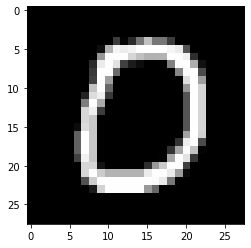

In [5]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 3
# predicted class
pred_class = class_name[np.argmax(pred_onnx[i_instance])]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][0], cmap='gray')  # 0 for channel

#### 2 - Compute and visualize the relevance attributions
Compute the relevance attributions using RISE and visualize them overlayed on the image. 

RISE masks random portions of the input image and passes the masked image through the model — the portion that decreases the accuracy the most is the most “important” portion.<br>
To call the explainer and generate the relevance scores, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [6]:
relevances = dianna.explain_image(run_model, X_test[i_instance], method="RISE",
                                labels=[i for i in range(2)],
                                n_masks=5000, feature_res=8, p_keep=.1,
                                axis_labels=('channels','height','width'))

Explaining: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 101.37it/s]


Visualize the relevance scores for the predicted class on top of the image.

Explanation for `digit 0`


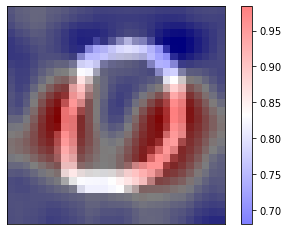

In [7]:
print(f'Explanation for `{pred_class}`')
fig, _ = visualization.plot_image(relevances[0], X_test[i_instance][0], data_cmap='gray')

#### 3 - Conclusions
The relevance scores are generated by passing multiple randomly masked inputs to the black-box model and averaging their pixel relevances. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score. <br>

The example here shows that the RISE method evaluates the relevance of each pixel/super pixel to the classification and highlights the lateral parts of the digit zero. This implies that the model determines whether the digit is 0 by checking the lateral parts. The results are reasonable compared to the human visual preception of the test image.